# Statement

# Project parts

[Work Plan](#Work-Plan)

[Additional Assignment](#Additional-Assignment)

[Solution Code](#Solution-Code)

[Solution Report](#Solution-Report)

In [1]:
# pip install --upgrade --user awscli

In [102]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from colorama import Fore
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score, roc_curve, f1_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
import catboost as cb
from catboost import CatBoostClassifier

## Work Plan

In [3]:
#Loading data
path='/datasets/final_provider/'
data = {}
data['contract'] = pd.read_csv(path+'contract.csv')
data['personal'] = pd.read_csv(path+'personal.csv')
data['internet'] = pd.read_csv(path+'internet.csv')
data['phone'] = pd.read_csv(path+'phone.csv')

In [4]:
#viewing general information
for name, file in data.items():
    print(Fore.BLUE,'\n****************\n', name,'\n****************\n', Fore.GREEN)
    print('\n', file.info(), Fore.YELLOW, file.describe(),'\n',Fore.BLACK, file.head(10),'\n')

 
****************
 contract 
****************
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

 None         MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000 
     customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-t

In [5]:
pd.to_datetime(data['contract']['BeginDate']).describe()

count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: BeginDate, dtype: object

In [6]:
pd.to_datetime(data['contract']['EndDate'].mask(data['contract']['EndDate']=='No')).describe()

count                    1869
unique                      4
top       2019-11-01 00:00:00
freq                      485
first     2019-10-01 00:00:00
last      2020-01-01 00:00:00
Name: EndDate, dtype: object

In [7]:
#Number of days from registration until termination or current date 2020-02-01
reg_days=(pd.to_datetime(data['contract']['EndDate'].str.replace('No','2020-02-01 00:00:00'))- \
 pd.to_datetime(data['contract']['BeginDate']))
reg_days.describe()

count                        7043
mean     985 days 23:54:28.777509
std      747 days 14:06:29.712340
min               0 days 00:00:00
25%             273 days 00:00:00
50%             883 days 00:00:00
75%            1676 days 00:00:00
max            2191 days 00:00:00
dtype: object

In [8]:
#Number of days from 2019-10-01 until termination or current date 2020-02-01 
left_days=pd.to_datetime(data['contract']['EndDate'].str.replace('No','2020-02-01 00:00:00'))- pd.to_datetime('2019-10-01')
left_days.describe()

count                        7043
mean     102 days 12:56:19.696152
std       38 days 06:42:55.352588
min               0 days 00:00:00
25%              92 days 00:00:00
50%             123 days 00:00:00
75%             123 days 00:00:00
max             123 days 00:00:00
Name: EndDate, dtype: object

In [9]:
#Share of customers with no end date
data['contract'][data['contract']['EndDate']=='No'].shape[0]/data['contract'].shape[0]

0.7346301292063041

- No aparent missing data
- Many 2-categorical columns that can be converted to numerical
- Numerical columns in object format needs to be converted
- Date columns needs to be converted to date parts
- We need to construct the target feature from EndDate column or from the total registration period
- We need to choose important features and combine them to one dataframe
- The company kept data of past customers who left in the past 4 months so the data about long-time customers is missleading since a model might find that a small begin year is correlated with longer registration period.
- Not all customers have internet or phone data

### Preprocessing

In [10]:
#Addind datetime columns and boolean ended column 
data['contract']['BeginDate_dt']=pd.to_datetime(data['contract']['BeginDate'])
data['contract']['EndDate_dt']=pd.to_datetime(data['contract']['EndDate'].mask(data['contract']['EndDate']=='No'))
data['contract'].loc[data['contract']['EndDate']=='No', 'Ended'] = 'No'
data['contract']['Ended'] = data['contract']['Ended'].fillna('Yes')


In [11]:
#Extracting date parts
for col in ['Begin','End']:
    for attr in ['year', 'month', 'day']:
            data['contract'].loc[:,col+'_'+attr] = getattr(data['contract'].loc[:,col+'Date_dt'].dt, attr)
data['contract'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
BeginDate_dt        7043 non-null datetime64[ns]
EndDate_dt          1869 non-null datetime64[ns]
Ended               7043 non-null object
Begin_year          7043 non-null int64
Begin_month         7043 non-null int64
Begin_day           7043 non-null int64
End_year            1869 non-null float64
End_month           1869 non-null float64
End_day             1869 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(3), object(8)
memory usage: 935.5+ KB


In [12]:
#Adding service period column
data['contract']['Reg_days_til_2020_Feb_01']=pd.to_numeric(reg_days.astype('timedelta64[D]'))

In [13]:
#Number of days from registration until 2019-09-30 (lasy day before recording terminations)
reg_days_till_20190930=pd.to_numeric((pd.to_datetime('2019-09-30')- \
                                     pd.to_datetime(data['contract']['BeginDate'])).astype('timedelta64[D]'))
reg_days_till_20190930[reg_days_till_20190930<0]=0
reg_days_till_20190930.describe()

count    7043.000000
mean      888.774528
std       728.641349
min         0.000000
25%       182.000000
50%       759.000000
75%      1582.000000
max      2190.000000
Name: BeginDate, dtype: float64

In [14]:
data['contract']['Reg_days_til_2019_sep_30']=reg_days_till_20190930

In [15]:
#Adding days left in the past 4 months column
data['contract']['days_left_last_4_months']=pd.to_numeric(left_days.astype('timedelta64[D]'))

In [16]:
data['internet']['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [17]:
data['contract']['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [18]:
numeric_totalcharges = pd.to_numeric(data['contract']['TotalCharges'].str.strip())

In [19]:
numeric_totalcharges.isna().sum()

11

In [20]:
data['contract'].loc[numeric_totalcharges.isna(),['customerID','TotalCharges', 'BeginDate'] ]

,customerID,TotalCharges,BeginDate
488,4472-LVYGI,,2020-02-01
753,3115-CZMZD,,2020-02-01
936,5709-LVOEQ,,2020-02-01
1082,4367-NUYAO,,2020-02-01
1340,1371-DWPAZ,,2020-02-01
3331,7644-OMVMY,,2020-02-01
3826,3213-VVOLG,,2020-02-01
4380,2520-SGTTA,,2020-02-01
5218,2923-ARZLG,,2020-02-01
6670,4075-WKNIU,,2020-02-01


All nulls are of last month customers and can be replaced with 0

In [21]:
#Converting TotalCharges to float
data['contract']['TotalCharges'] = numeric_totalcharges.fillna(0)

In [22]:
data['contract'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID                  7043 non-null object
BeginDate                   7043 non-null object
EndDate                     7043 non-null object
Type                        7043 non-null object
PaperlessBilling            7043 non-null object
PaymentMethod               7043 non-null object
MonthlyCharges              7043 non-null float64
TotalCharges                7043 non-null float64
BeginDate_dt                7043 non-null datetime64[ns]
EndDate_dt                  1869 non-null datetime64[ns]
Ended                       7043 non-null object
Begin_year                  7043 non-null int64
Begin_month                 7043 non-null int64
Begin_day                   7043 non-null int64
End_year                    1869 non-null float64
End_month                   1869 non-null float64
End_day                     1869 non-null float64
Reg_days_til_2020_Feb_01    7043 non-null 

### EDA

Text(0, 0.5, 'Number of customers')

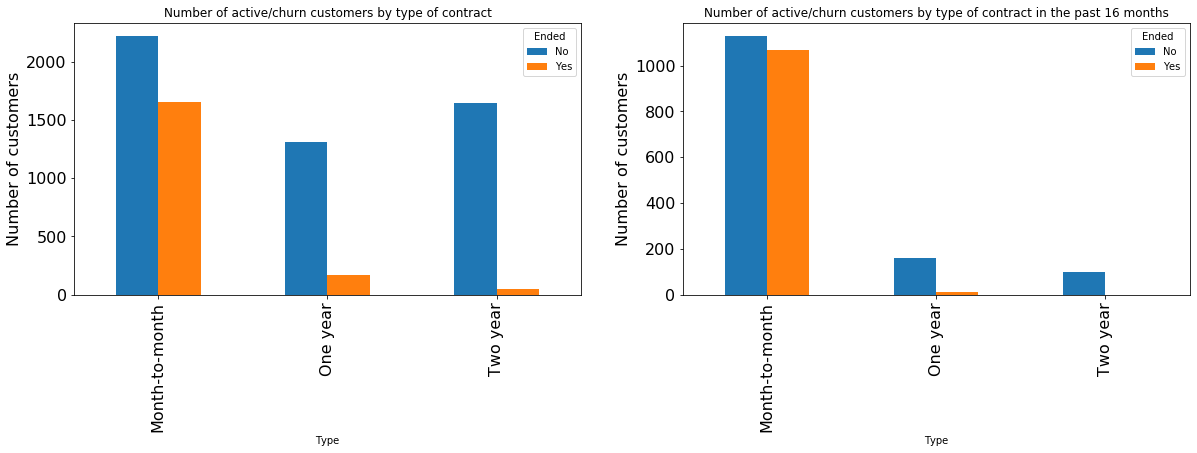

In [23]:
#Churns per type of contract
fig, axs = plt.subplots(1,2,figsize=(20,5))
ax=axs[0]
data['contract'].groupby(['Type','Ended'])['Ended'].count().unstack().plot.bar \
(fontsize=16, title='Number of active/churn customers by type of contract', ax=ax)
ax.set_ylabel('Number of customers', fontsize=16)
ax=axs[1]
data['contract'].query('BeginDate_dt >= "2018-10-01"').groupby(['Type','Ended'])['Ended'].count().unstack().plot.bar \
( fontsize=16, title='Number of active/churn customers by type of contract in the past 16 months', ax=ax)
ax.set_ylabel('Number of customers', fontsize=16)

The type of contract is an obvious feature because a customer on a one-year contract wouldn't leave during that year

Text(0, 0.5, 'Number of customers')

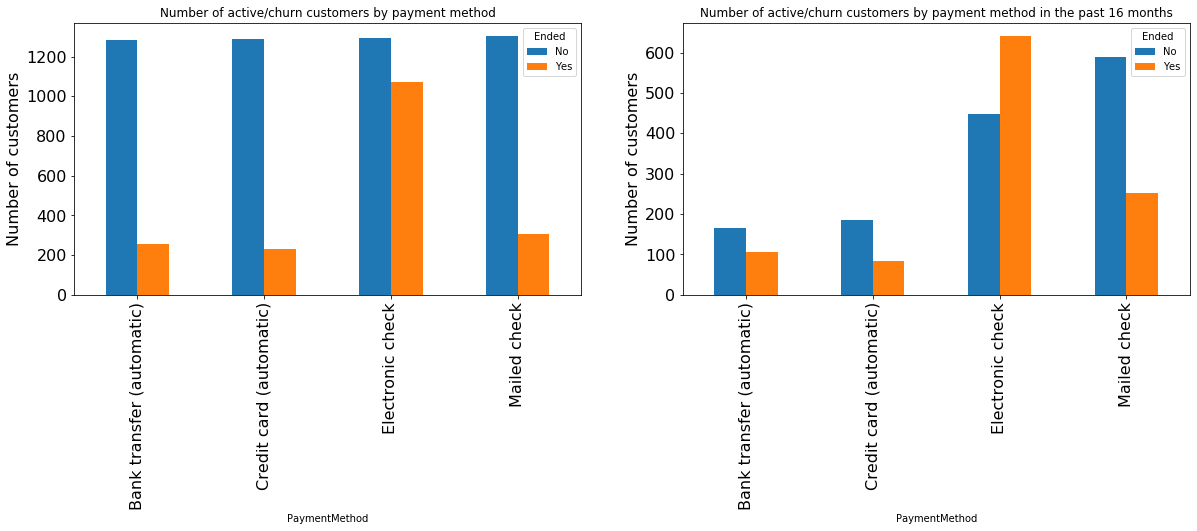

In [24]:
#Churns per Payment Method
fig, axs = plt.subplots(1,2,figsize=(20,5))
ax=axs[0]
data['contract'].groupby(['PaymentMethod','Ended'])['Ended'].count().unstack().plot.bar \
(fontsize=16, title='Number of active/churn customers by payment method', ax=ax)
ax.set_ylabel('Number of customers', fontsize=16)
ax=axs[1]
data['contract'].query('BeginDate_dt >= "2018-10-01"').groupby(['PaymentMethod','Ended'])['Ended'].count().unstack().plot.bar \
( fontsize=16, title='Number of active/churn customers by payment method in the past 16 months', ax=ax)
ax.set_ylabel('Number of customers', fontsize=16)

Payment Method seems to be a relevant feature since there's bigger chance to end the service when payment is manual and digital.

Text(0, 0.5, 'Number of customers')

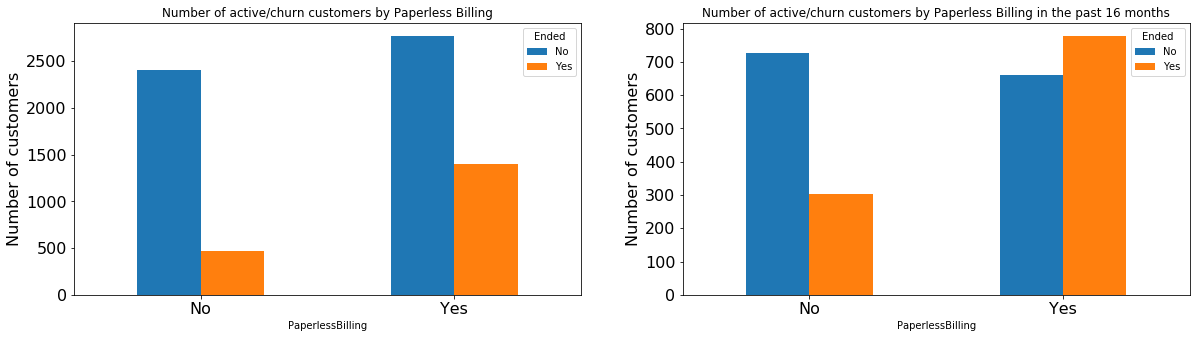

In [25]:
#Churns per Paperless Billing
fig, axs = plt.subplots(1,2,figsize=(20,5))
ax=axs[0]
data['contract'].groupby(['PaperlessBilling','Ended'])['Ended'].count().unstack().plot.bar \
(fontsize=16, title='Number of active/churn customers by Paperless Billing', ax=ax, rot=0)
ax.set_ylabel('Number of customers', fontsize=16)
ax=axs[1]
data['contract'].query('BeginDate_dt >= "2018-10-01"').groupby(['PaperlessBilling','Ended'])['Ended'].count().unstack().plot.bar \
( fontsize=16, title='Number of active/churn customers by Paperless Billing in the past 16 months', ax=ax, rot=0)
ax.set_ylabel('Number of customers', fontsize=16)

PaperlessBilling is also relevant with bigger chance to end when billing is paperless (probably younger customers?) 

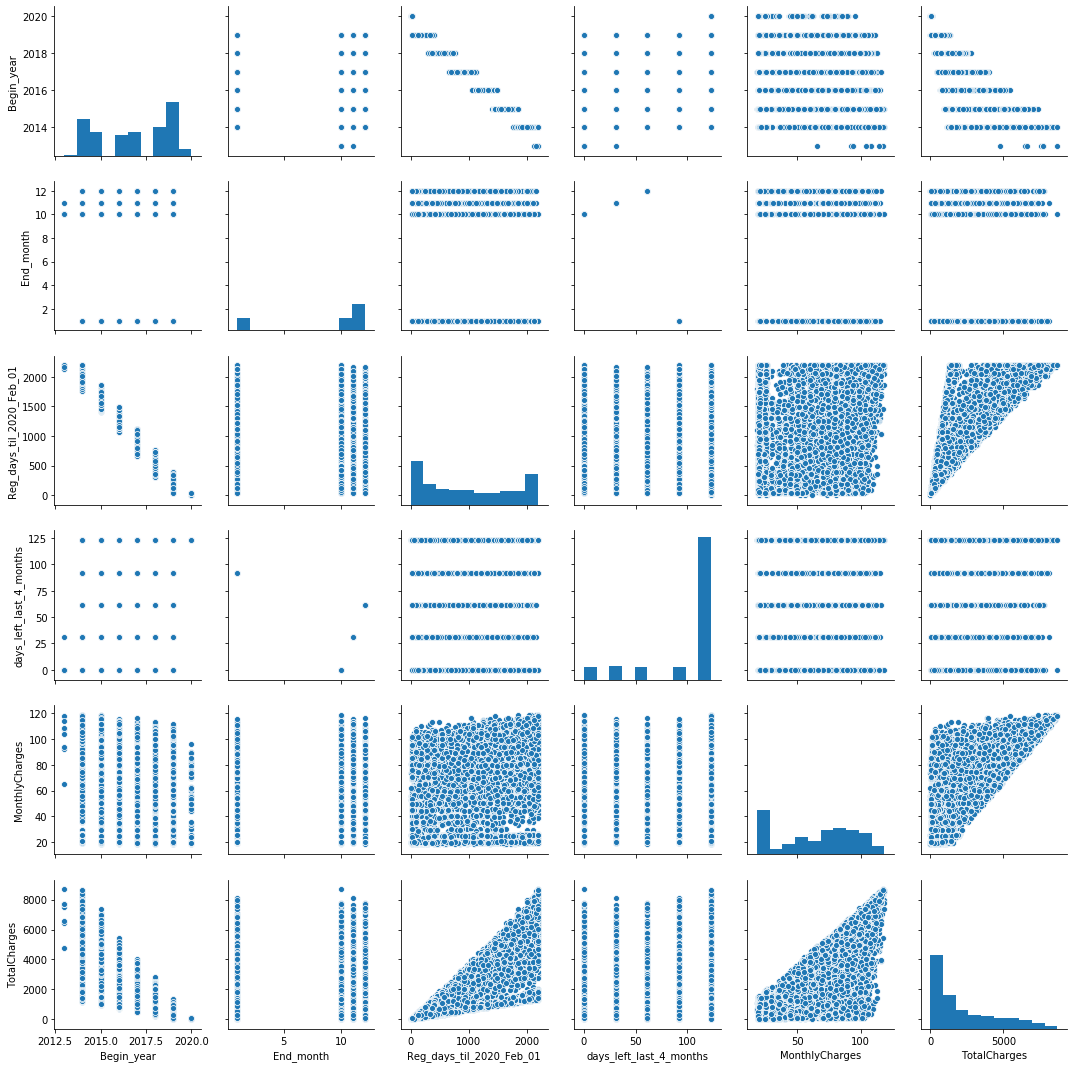

In [26]:
#Viewing relationships between pairs of numerical columns
sns.pairplot(data['contract'].loc[:, ['Begin_year','End_month','Reg_days_til_2020_Feb_01','days_left_last_4_months','MonthlyCharges', 'TotalCharges']],\
             diag_kind='hist')

I don't see any interesting corralation between the numerical columns.

In [27]:
# Correlation between 'Reg_months_til_2020_Feb_01' , 'TotalCharges'/'MonthlyCharges' and 'Ended'
data['contract']['Reg_days_til_2020_Feb_01'].corr(data['contract']['TotalCharges']/data['contract']['MonthlyCharges'])

0.9989339669907599

This means a model will be able to determine the number of active months from the combination of 'TotalCharges', 'MonthlyCharges'

In [29]:
(data['contract']['Ended'].map({'No': 0, 'Yes': 1})).corr(data['contract']['Reg_days_til_2020_Feb_01'])

-0.3526731038544403

In [ ]:
(data['contract']['Ended'].map({'No': 0, 'Yes': 1})).corr \
(data['contract']['Reg_days_til_2020_Feb_01']-(data['contract']['MonthlyCharges']))

In [ ]:
(data['contract']['Ended'].map({'No': 0, 'Yes': 1})).corr(data['contract']['Begin_month']-data['contract']['TotalCharges']/data['contract']['MonthlyCharges'])

In [ ]:
#Examining number of customers in relation to begin / end times
plt.figure(figsize=(20,5));
plt.subplot(1,2,1)
plt.hist(data['contract']['BeginDate_dt'],bins=7)
plt.xlabel('Begin Year', fontsize=14)
plt.ylabel('Number of customers', fontsize=14)
plt.title('Number of customers by begin year', fontsize=16)

plt.subplot(1,2,2)
data['contract'].groupby(['End_month'])['End_month'].count().plot.bar(rot=0)
plt.xlabel('End month', fontsize=14)
plt.ylabel('Number of customers', fontsize=14)
plt.title('Number of customers by end month', fontsize=16)

data['contract'].groupby(['Begin_month', 'Ended'])['Ended'].count().unstack().plot.bar(stacked=True, rot=0)
plt.xlabel('Begin month', fontsize=14)
plt.ylabel('Number of customers', fontsize=14)
plt.title('Number of customers by begin month', fontsize=16)

- We have much more data on new customers since the company didn't keep the data on customers who left before 2019-Oct-01 
- Similar number of cutomers left each month
- Begin month seems to be somewhat relevant as a feature but might be influenced from the peak in new customers in late 2019 till the begining of 2020

In [ ]:
#Examining monthly charges
plt.figure(figsize=(20,5));
plt.subplot(1,2,1)
plt.hist(data['contract']['MonthlyCharges'],bins=10)
plt.xlabel('Monthly Charges', fontsize=14)
plt.ylabel('Number of customers', fontsize=14)
plt.title('Number of customers by Monthly Charges', fontsize=16)
plt.subplot(1,2,2)
plt.figure;
plt.plot(data['contract'].set_index('BeginDate_dt')['MonthlyCharges'].resample('1M').mean())
plt.xlabel('Begin Date', fontsize=14)
plt.ylabel('Monthly Charges', fontsize=14)
plt.title('Monthly charges vs. Begin year (avg. one month)', fontsize=16)

- The most popular plans are the cheep ones
- The average monthly charges are slightly decreasing over the years

Text(0.5, 1.0, 'Number of customers by Total Charges')

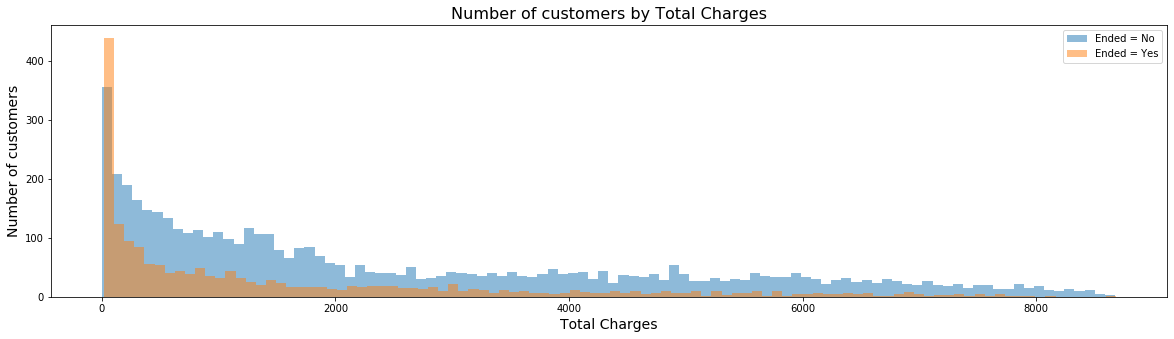

In [31]:
#Examining total charges
plt.figure(figsize=(20,5));
plt.hist(data['contract'].query('Ended == "No"')['TotalCharges'], alpha=0.5,bins=100, label='Ended = No')
plt.hist(data['contract'].query('Ended == "Yes"')['TotalCharges'], alpha=0.5,bins=100, label='Ended = Yes')
plt.legend()
plt.xlabel('Total Charges', fontsize=14)
plt.ylabel('Number of customers', fontsize=14)
plt.title('Number of customers by Total Charges', fontsize=16)

In [32]:
data['personal']=data['personal'].merge(data['contract'].loc[:,['customerID','BeginDate_dt','Ended']], on='customerID')

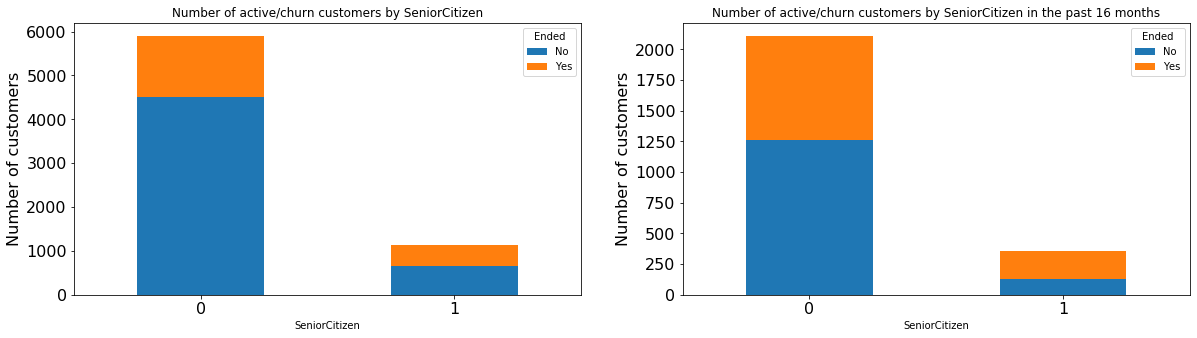

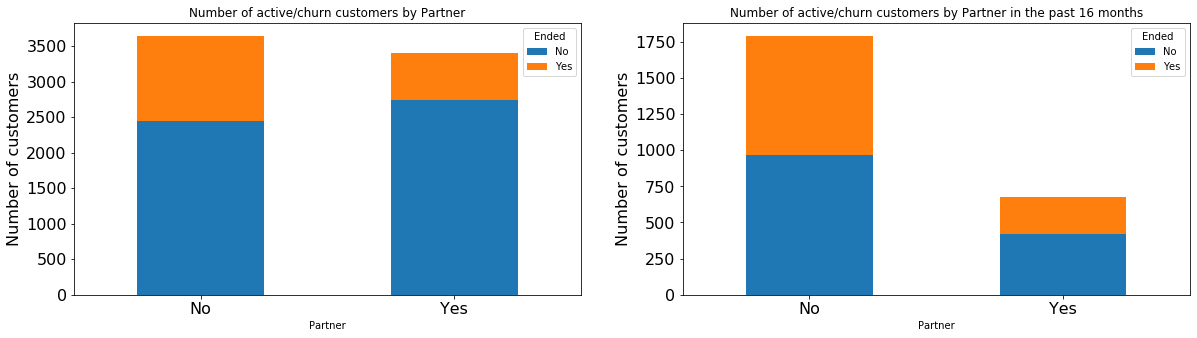

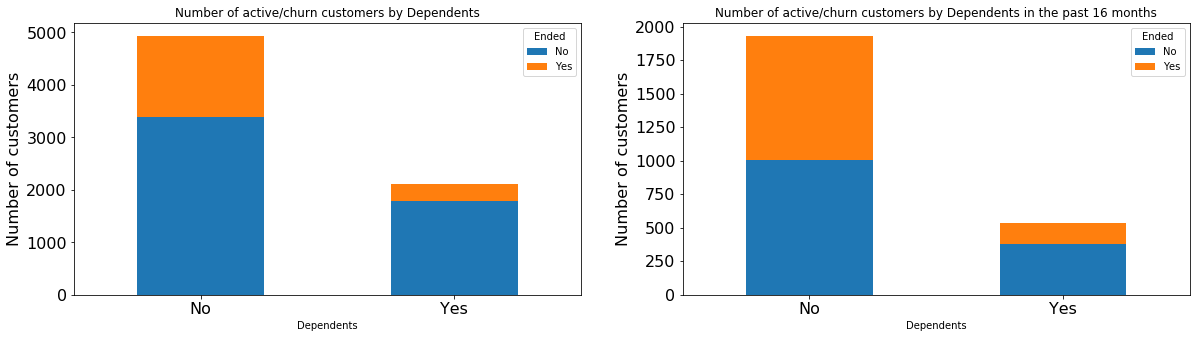

In [33]:
for col in ['SeniorCitizen', 'Partner','Dependents']:
    fig, axs = plt.subplots(1,2,figsize=(20,5))
    ax=axs[0]
    data['personal'].groupby([col,'Ended'])['Ended'].count().unstack().plot.bar \
    (stacked=True, fontsize=16, title='Number of active/churn customers by '+ col, ax=ax, rot=0)
    ax.set_ylabel('Number of customers', fontsize=16)
    ax=axs[1]
    data['personal'].query('BeginDate_dt >= "2018-10-01"').groupby([col,'Ended'])['Ended'].count().unstack().plot.bar \
    (stacked=True, fontsize=16, title='Number of active/churn customers by '+col+ ' in the past 16 months', ax=ax, rot=0)
    ax.set_ylabel('Number of customers', fontsize=16)

- Bigger ratio of senior citizens ended the service
- A slightly bigger ratio of customers who don't have a partner ended the service
- bigger ratio of customers who don't have dependents ended the service

In [34]:
data['internet']=data['internet'].merge(data['contract'].loc[:,['customerID','Ended']], on='customerID', how='left')

In [35]:
data['phone']=data['phone'].merge(data['contract'].loc[:,['customerID','Ended']], on='customerID', how='left')

Text(0, 0.5, 'Number of customers')

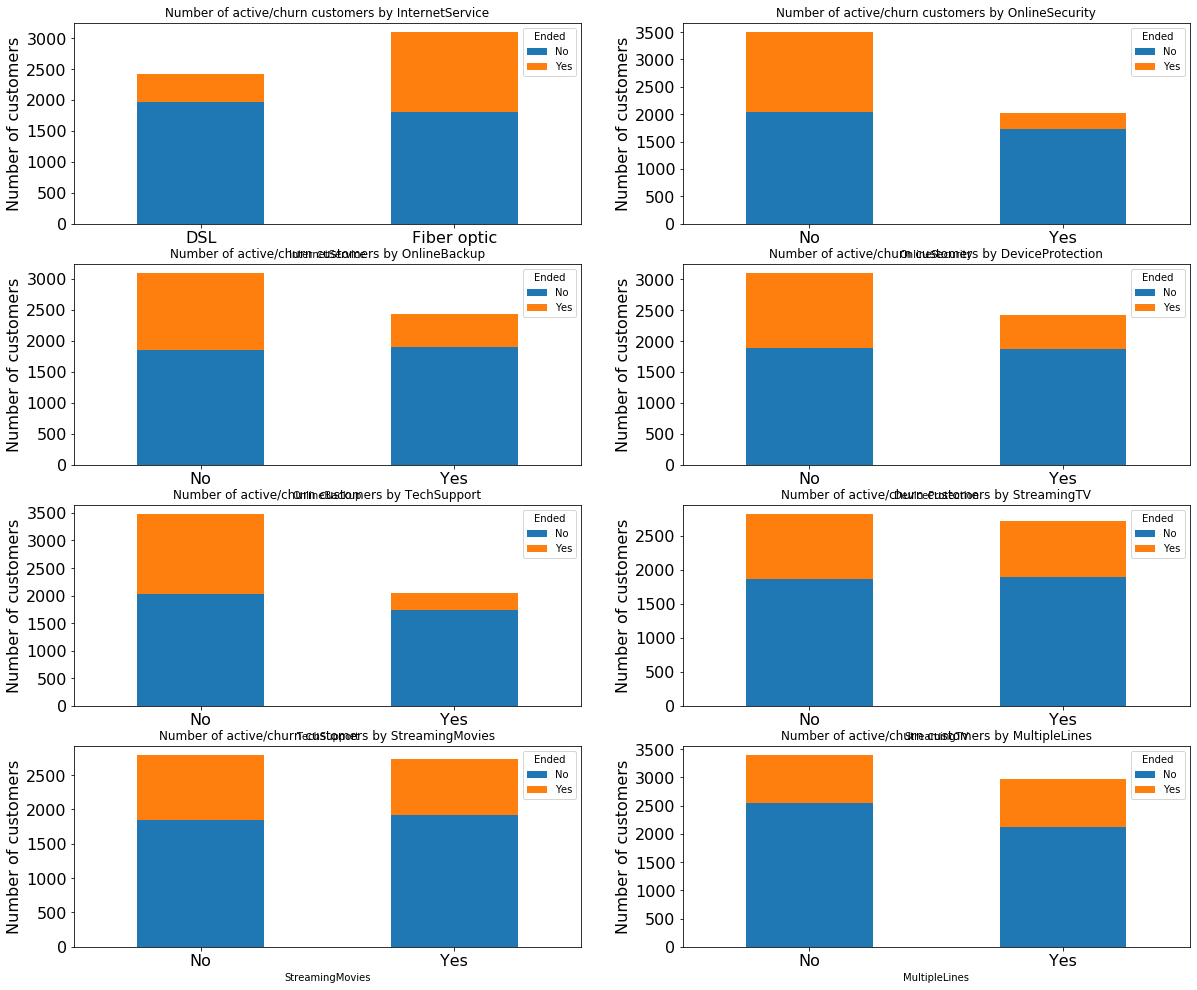

In [36]:
fig, axs = plt.subplots(4,2,figsize=(20,17))
i=0
j=0
for col in \
['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    ax=axs[i][j]
    data['internet'].groupby([col,'Ended'])['Ended'].count().unstack().plot.bar \
    (stacked=True, fontsize=16, title='Number of active/churn customers by '+ col, ax=ax, rot=0)
    ax.set_ylabel('Number of customers', fontsize=16)
    j+=1
    if j==2: 
        i+=1
        j=0
ax=axs[3][1]
data['phone'].groupby(['MultipleLines','Ended'])['Ended'].count().unstack().plot.bar \
(stacked=True, fontsize=16, title='Number of active/churn customers by MultipleLines', ax=ax, rot=0)
ax.set_ylabel('Number of customers', fontsize=16)

Relevant features: InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport

 EDA conclusion:

- Interesting columns to consider as features: Begin_month, MonthlyCharges, PaperlessBilling, PaymentMethod, Type, SeniorCitizen, Partner,Dependents, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, MultipleLines
- We must take into account the fact that there's churn data for only 4 months and classes are strongly imbalanced
- Internet and Phone features have MNAR values (those customers weren't registered to the service) with regards to the full dataset and those must be replaced with a new category

### Clarifying questions

1. Does the company wishes to forecast their churn of clients in terms of classification of ending the service in the coming 4 months, or in terms of a predicted length of time until termination in the coming 4 months /  a predicted length of time for being an active user in total?


2. In the case of regression of days left as a customer in the coming 4 month, should I convert all the dates to the time differences relative to "today" (2019-10-01 for this data) ?


3. Do you have a reccomendation on how to handle the classes imbalance and the fact that data of long-time customers is available only for those who are still active or ended in the past 4 months?


4. Are there any technical/time restrictions for the model training?

### Plan

1. Constracting features and target:
    Choosing the important features, merging them into one dataset. Understanding the required prediction type and creating a target feature from the available data. Additional preprocessing and reserving a test data.


2. Choosing the suitable metric and objective:
    How to evaluate the model with regards to the prediction type and the business needs.
    
    
3. Choosing and tuning a model:
    Training a few models to find the suitable one for good metric scores.


4. Explaining the reliability of the model and consequences of using it:
    The business meaning of the acquired score, the risk of taking actions according to the model's suggestions (the cases of false-positive and false-negative mistakes) 

## Additional Assignment

In [37]:
#statistics for Active customers
print('Active customers statistics:\n')
data['contract'].query('Ended=="No"')['MonthlyCharges'].describe()

Active customers statistics:



count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [38]:
#statistics for customers who have left
print('Leaving customers statistics:\n')
data['contract'].query('Ended=="Yes"')['MonthlyCharges'].describe()

Leaving customers statistics:



count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

Text(0.5, 1.0, 'Number of customers by Monthly Charges')

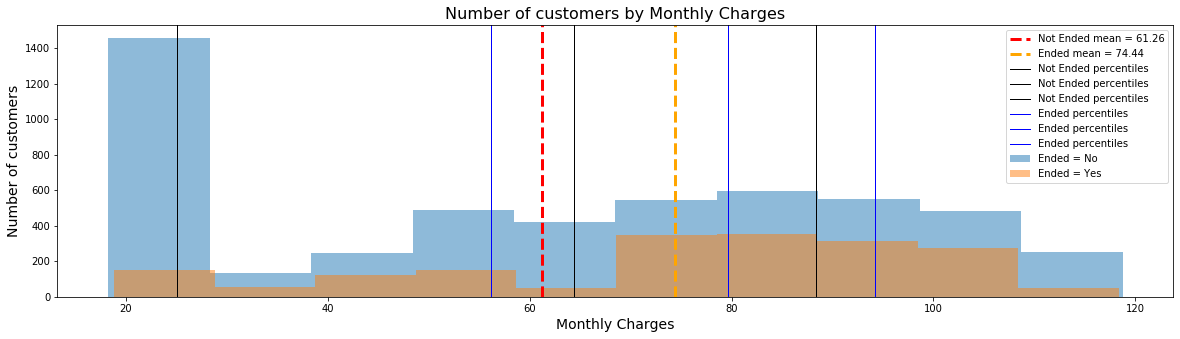

In [39]:
#Examining MonthlyCharges
plt.figure(figsize=(20,5));

plt.axvline(61.26, color='r', linestyle='dashed', linewidth=3, label='Not Ended mean = 61.26')
plt.axvline(74.44, color='orange', linestyle='dashed', linewidth=3, label='Ended mean = 74.44')

[plt.axvline(x, color='k', linestyle='solid', linewidth=1, label='Not Ended percentiles') for x in [25.1,64.42,88.4]]
[plt.axvline(x, color='b', linestyle='solid', linewidth=1, label='Ended percentiles') for x in [56.15,79.65,94.2]]

plt.hist(data['contract'].query('Ended == "No"')['MonthlyCharges'], alpha=0.5,bins=10, label='Ended = No')
plt.hist(data['contract'].query('Ended == "Yes"')['MonthlyCharges'], alpha=0.5,bins=10, label='Ended = Yes')
plt.legend()
plt.xlabel('Monthly Charges', fontsize=14)
plt.ylabel('Number of customers', fontsize=14)
plt.title('Number of customers by Monthly Charges', fontsize=16)

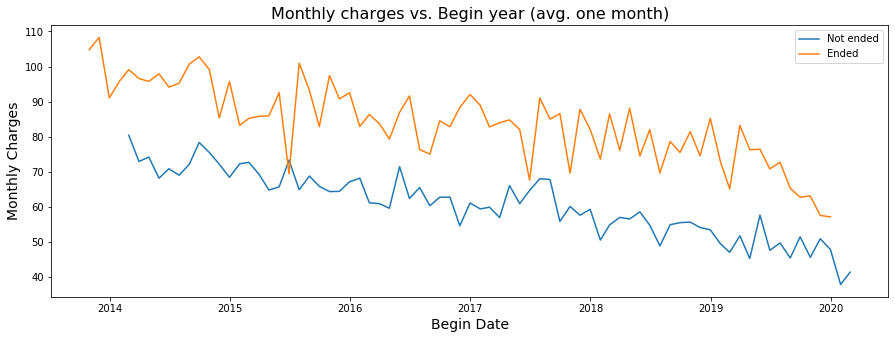

In [40]:
plt.figure(figsize=(15,5));
plt.plot(data['contract'].set_index('BeginDate_dt').query('Ended=="No"')['MonthlyCharges'].resample('1M').mean(), label='Not ended')
plt.plot(data['contract'].set_index('BeginDate_dt').query('Ended=="Yes"')['MonthlyCharges'].resample('1M').mean(), label='Ended')
plt.xlabel('Begin Date', fontsize=14)
plt.ylabel('Monthly Charges', fontsize=14)
plt.title('Monthly charges vs. Begin year (avg. one month)', fontsize=16)
plt.legend()

- It is clear that Monthly Charges plays an important role in the probability of a custome to leave. 
- The shares of ended customers are larger for prices between 70-110 compared to other price groups.
- The Ended group mean is 20% larger than active group's. 
- The 25% percentile of the ended group is more than twice than the active group, but that also due to the face that monthly charges decreased over the years and we have more data of recent customers.
- There's a steady gap between the groupss' monthly charges over the years (graphs rarely intersect) which indicate a possible retaining of a customer simply by transferring him to the lower price group.

Text(0, 0.5, 'Number of customers')

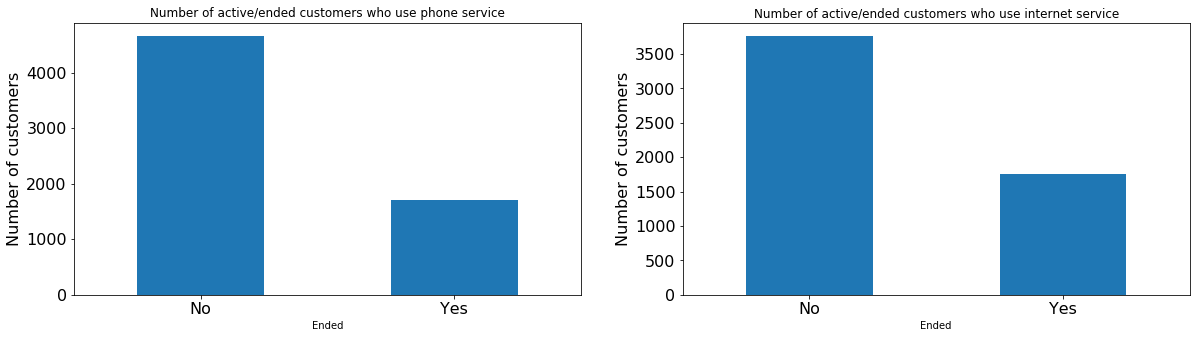

In [41]:
fig, axs = plt.subplots(1,2,figsize=(20,5))
ax=axs[0]
data['phone'].groupby(['Ended']).count()['customerID'].plot.bar \
(stacked=True, fontsize=16, title='Number of active/ended customers who use phone service', ax=ax, rot=0)
ax.set_ylabel('Number of customers', fontsize=16)
ax=axs[1]
data['internet'].groupby(['Ended']).count()['customerID'].plot.bar \
(stacked=True, fontsize=16, title='Number of active/ended customers who use internet service', ax=ax, rot=0)
ax.set_ylabel('Number of customers', fontsize=16)

Text(0.5, 1.0, 'Share of ended-users in phone\\internet out of total ended')

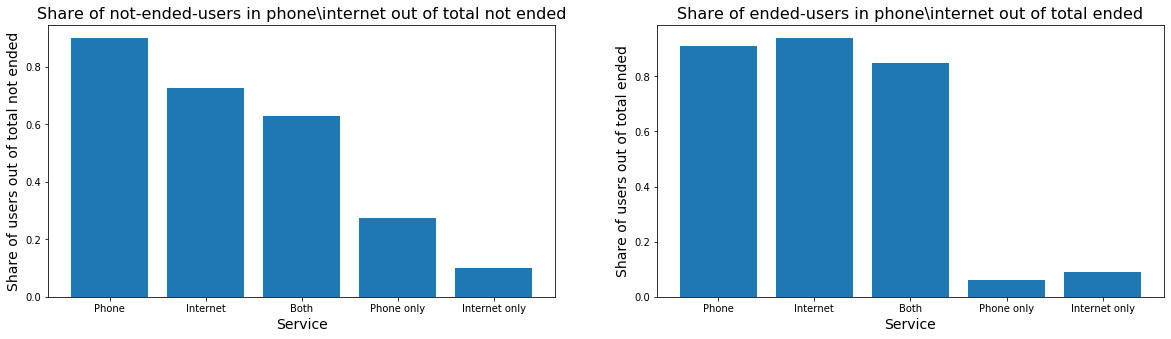

In [42]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.bar(['Phone', 'Internet', 'Both', 'Phone only', 'Internet only'], \
        \
       [data['phone'].query('Ended=="No"').shape[0]/data['contract'].query('Ended=="No"').shape[0], \
        \
       data['internet'].query('Ended=="No"').shape[0]/data['contract'].query('Ended=="No"').shape[0], \
        \
       len(data['phone'].query('Ended=="No"').set_index('customerID').index. \
        intersection(data['internet'].query('Ended=="No"').set_index('customerID').index))/ \
        data['contract'].query('Ended=="No"').shape[0], \
        \
       len(data['phone'].query('Ended=="No"').set_index('customerID').index. \
        difference(data['internet'].query('Ended=="No"').set_index('customerID').index))/ \
        data['contract'].query('Ended=="No"').shape[0], \
        \
        len(data['internet'].query('Ended=="No"').set_index('customerID').index. \
        difference(data['phone'].query('Ended=="No"').set_index('customerID').index))/ \
        data['contract'].query('Ended=="No"').shape[0]
       ])
plt.xlabel('Service', fontsize=14)
plt.ylabel('Share of users out of total not ended', fontsize=14)
plt.title('Share of not-ended-users in phone\internet out of total not ended', fontsize=16)

plt.subplot(1,2,2)
plt.bar(['Phone', 'Internet', 'Both', 'Phone only', 'Internet only'], \
        \
       [data['phone'].query('Ended=="Yes"').shape[0]/data['contract'].query('Ended=="Yes"').shape[0], \
        \
       data['internet'].query('Ended=="Yes"').shape[0]/data['contract'].query('Ended=="Yes"').shape[0], \
        \
       len(data['phone'].query('Ended=="Yes"').set_index('customerID').index. \
        intersection(data['internet'].query('Ended=="Yes"').set_index('customerID').index))/ \
        data['contract'].query('Ended=="Yes"').shape[0], \
        \
       len(data['phone'].query('Ended=="Yes"').set_index('customerID').index. \
        difference(data['internet'].query('Ended=="Yes"').set_index('customerID').index))/ \
        data['contract'].query('Ended=="Yes"').shape[0], \
        \
        len(data['internet'].query('Ended=="Yes"').set_index('customerID').index. \
        difference(data['phone'].query('Ended=="Yes"').set_index('customerID').index))/ \
        data['contract'].query('Ended=="Yes"').shape[0]
       ])
plt.xlabel('Service', fontsize=14)
plt.ylabel('Share of users out of total ended', fontsize=14)
plt.title('Share of ended-users in phone\internet out of total ended', fontsize=16)

- We can see significant differences in Not Ended \ Ended groups regarding the phone \ internet use.
- In both groupf about 90% of customers used phone service.
- In Not Ended group only about 70% used internet compared to more than 90% in Ended.
- This could explain part of the the difference in monthly charges - more users who ended were registered to both services (~85%) and thus paid larger prices, while only ~60% of active users are registered to both services. 

## Solution Code

### Constracting features and target

In [141]:
data['internet_phone'] = data['internet'].drop('Ended', axis=1). \
merge(data['phone'].drop('Ended', axis=1), how='outer', on='customerID')

In [144]:
data['internet_phone'].head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,No


In [145]:
data['internet_phone'].loc[:,['InternetService', 'MultipleLines']] = \
                           data['internet_phone'].loc[:,['InternetService', 'MultipleLines']].fillna('Not_Registered')
data['internet_phone'] = data['internet_phone'].fillna('No')                           

In [146]:
data['internet_phone']

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,Not_Registered
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,Not_Registered
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...
7038,4807-IZYOZ,Not_Registered,No,No,No,No,No,No,No
7039,9710-NJERN,Not_Registered,No,No,No,No,No,No,No
7040,9837-FWLCH,Not_Registered,No,No,No,No,No,No,No
7041,0871-OPBXW,Not_Registered,No,No,No,No,No,No,No


In [148]:
data['personal']=data['personal'].drop(['BeginDate_dt','Ended'],axis=1)
data['full']=data['contract'].merge(data['personal'], on='customerID').merge(data['internet_phone'], on='customerID')

In [149]:
data['full'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 32 columns):
customerID                  7043 non-null object
BeginDate                   7043 non-null object
EndDate                     7043 non-null object
Type                        7043 non-null object
PaperlessBilling            7043 non-null object
PaymentMethod               7043 non-null object
MonthlyCharges              7043 non-null float64
TotalCharges                7043 non-null float64
BeginDate_dt                7043 non-null datetime64[ns]
EndDate_dt                  1869 non-null datetime64[ns]
Ended                       7043 non-null object
Begin_year                  7043 non-null int64
Begin_month                 7043 non-null int64
Begin_day                   7043 non-null int64
End_year                    1869 non-null float64
End_month                   1869 non-null float64
End_day                     1869 non-null float64
Reg_days_til_2020_Feb_01    7043 non-null 

In [155]:
data['for_model']=data['full'].drop(['customerID','Begin_month', 'Reg_days_til_2019_sep_30','BeginDate','EndDate','BeginDate_dt', 'EndDate_dt','Begin_year','Begin_day','End_year', \
                                     'End_month', 'End_day', 'days_left_last_4_months','StreamingTV', 'StreamingMovies'], axis=1)

In [156]:
data['for_model'].nunique()

Type                           3
PaperlessBilling               2
PaymentMethod                  4
MonthlyCharges              1585
TotalCharges                6531
Ended                          2
Reg_days_til_2020_Feb_01     156
gender                         2
SeniorCitizen                  2
Partner                        2
Dependents                     2
InternetService                3
OnlineSecurity                 2
OnlineBackup                   2
DeviceProtection               2
TechSupport                    2
MultipleLines                  3
dtype: int64

In [157]:
# Ended encoding
data['for_model'].loc[:,'Ended'] = data['for_model'].loc[:,'Ended'].map({'No': 0, 'Yes': 1})

In [158]:
data['for_model']=pd.get_dummies(data['for_model'], drop_first=True)

In [159]:
data['for_model'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
MonthlyCharges                           7043 non-null float64
TotalCharges                             7043 non-null float64
Ended                                    7043 non-null int64
Reg_days_til_2020_Feb_01                 7043 non-null float64
SeniorCitizen                            7043 non-null int64
Type_One year                            7043 non-null uint8
Type_Two year                            7043 non-null uint8
PaperlessBilling_Yes                     7043 non-null uint8
PaymentMethod_Credit card (automatic)    7043 non-null uint8
PaymentMethod_Electronic check           7043 non-null uint8
PaymentMethod_Mailed check               7043 non-null uint8
gender_Male                              7043 non-null uint8
Partner_Yes                              7043 non-null uint8
Dependents_Yes                           7043 non-null uint8
InternetService_Fiber optic      

In [160]:
# Imbalance ratio
data['for_model']['Ended'].mean()

0.2653698707936959

In [161]:
# Reseving test set
features_train, features_test, target_train, target_test = \
    train_test_split(data['for_model'].drop(['Ended'] , axis=1), data['for_model']['Ended'], \
                     test_size=0.25, random_state=12345)
#checking balance
print('train 1s: ', target_train.mean(), 'test 1s: ',target_test.mean() )

train 1s:  0.26410450586898904 test 1s:  0.26916524701873934


### Metric

- The task is classification of customers who ended the service
- Metric: ROC-AUC that takes the area under TPR-FPR curves and gives similar weight for the success of the model in spotting leaving customers but not mistaking active ones.

### Training models

#### Constant Model

For ROCAUC it doesn't metter if we choose a constant model of 1's or 0's because it's always 0.5 for random model. For accuracy it's better to choose 0's as they are teh majority class.

In [162]:
const_model = DummyClassifier(strategy='constant', constant=0).fit(features_train, target_train)
pred_const = const_model.predict(features_train)
pred_proba_const = const_model.predict_proba(features_train)[:, 1]

In [163]:
roc_auc_score(target_train,pred_proba_const )

0.5

In [164]:
accuracy_score(target_train, pred_const)

0.735895494131011

In [165]:
f1_score(target_train, pred_const)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

#### Random Forest

In [166]:
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10, random_state=12345)


In [167]:
scores_RF_class_weight={}
for n in [20,70,100,200,500]:
    RF_model = RandomForestClassifier(n_estimators=n,criterion='gini', max_depth=8, class_weight='balanced_subsample', random_state=12345)
    scores_RF_class_weight[n] = \
    cross_validate(estimator=RF_model, X=features_train, y=target_train,scoring=['roc_auc', 'accuracy', 'f1'], cv=cv)

In [168]:
for key, val in scores_RF_class_weight.items():
    print('n: ', key, ' ROCAUC mean: ', round(np.mean(val['test_roc_auc']),4), \
         ' Accuracy mean: ', round(np.mean(val['test_accuracy']),4), \
         'F1 mean: ', round(np.mean(val['test_f1']),4))

n:  20  ROCAUC mean:  0.8528  Accuracy mean:  0.7788 F1 mean:  0.64
n:  70  ROCAUC mean:  0.8578  Accuracy mean:  0.7815 F1 mean:  0.6432
n:  100  ROCAUC mean:  0.8578  Accuracy mean:  0.781 F1 mean:  0.6425
n:  200  ROCAUC mean:  0.8583  Accuracy mean:  0.7811 F1 mean:  0.6431
n:  500  ROCAUC mean:  0.8583  Accuracy mean:  0.7815 F1 mean:  0.6436


In [169]:
scores_RF_class_weight2={}
for n in [20,70,100,200,500]:
    RF_model = RandomForestClassifier(n_estimators=n,criterion='gini', max_depth=8, class_weight='balanced', random_state=12345)
    scores_RF_class_weight2[n] = \
    cross_validate(estimator=RF_model, X=features_train, y=target_train,scoring=['roc_auc', 'accuracy', 'f1'], cv=cv)

In [170]:
for key, val in scores_RF_class_weight2.items():
    print('n: ', key, ' ROCAUC mean: ', round(np.mean(val['test_roc_auc']),4), \
         ' Accuracy mean: ', round(np.mean(val['test_accuracy']),4), \
         'F1 mean: ', round(np.mean(val['test_f1']),4))

n:  20  ROCAUC mean:  0.8526  Accuracy mean:  0.7776 F1 mean:  0.6385
n:  70  ROCAUC mean:  0.8579  Accuracy mean:  0.782 F1 mean:  0.6439
n:  100  ROCAUC mean:  0.8578  Accuracy mean:  0.7814 F1 mean:  0.6433
n:  200  ROCAUC mean:  0.8582  Accuracy mean:  0.7817 F1 mean:  0.6442
n:  500  ROCAUC mean:  0.8582  Accuracy mean:  0.7818 F1 mean:  0.6441


ROC-AUC scores are not good enough.

#### XGBoost

In [171]:
def xgb_tune(params, param_tune, features_train, target_train):
    est = XGBClassifier(**params)
    gsearch = GridSearchCV(estimator = est, param_grid = param_tune, scoring='roc_auc',n_jobs=4,iid=False, cv=4)
    gsearch.fit(features_train, target_train)
    print(gsearch.best_params_, gsearch.best_score_)
    return gsearch

In [172]:
# Converting sets to Dmatrix
xgtrain = xgb.DMatrix(features_train, label=target_train)
xgtest = xgb.DMatrix(features_test, label=target_test)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [173]:
# Tuning n_estimators for initial parameters setting
params = {
    'learning_rate': 0.1,
 'n_estimators':1000,
 'max_depth':5,
 'min_child_weight':1,
 'gamma':0,
 'subsample':0.8,
 'colsample_bytree':0.8,
 'objective': 'binary:logistic',
 'nthread':4,
 'scale_pos_weight':3,
 'seed':27
}

cvresult = xgb.cv(params, xgtrain, num_boost_round=params['n_estimators'], nfold=4, metrics='auc', early_stopping_rounds=50, \
                 stratified =True)
cvresult.shape[0]

391

Tuning max_depth, min_child_weight to control overfitting:

In [174]:
# Updating n_estimators and tuning max_depth, min_child_weight
params['n_estimators'] = cvresult.shape[0]
param_tune1 = {
 'max_depth':range(3,10,1),
 'min_child_weight':range(1,6,1)
}
gsearch1 = xgb_tune(params, param_tune1, features_train, target_train)

{'max_depth': 4, 'min_child_weight': 1} 0.8913313013936102


Tuning gamma to reduce splits in training:

In [175]:
# Updating max_depth, min_child_weight and tuning gamma
params['max_depth']=gsearch1.best_params_['max_depth']
params['min_child_weight']=gsearch1.best_params_['min_child_weight']
param_tune2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = xgb_tune(params, param_tune2, features_train, target_train)

{'gamma': 0.1} 0.8916541793929609


In [176]:
# Updating gamma and re-tuning n_estimators
params['gamma']=gsearch2.best_params_['gamma']
cvresult = xgb.cv(params, xgtrain, num_boost_round=params['n_estimators'], nfold=4, metrics='auc', early_stopping_rounds=50, \
                 stratified =True)
cvresult.shape[0]

391

Tuning scale_pos_weight because the data is imbalanced:

In [177]:
#  Updating n_estimators and tuning scale_pos_weight
params['n_estimators']=cvresult.shape[0]
param_tune3 = {
    'scale_pos_weight':[1,2,3,4,5,6,7,8,9,10]
}
gsearch3 = xgb_tune(params, param_tune3, features_train, target_train)

{'scale_pos_weight': 9} 0.8925323051153597


Tuning subsample and colsample_bytree to reduce overfitting:

In [178]:
#  Updating scale_pos_weight and tuning subsample and colsample_bytree
params['scale_pos_weight']=gsearch3.best_params_['scale_pos_weight']
param_tune4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = xgb_tune(params, param_tune4, features_train, target_train)

{'colsample_bytree': 0.6, 'subsample': 0.9} 0.8940391935585208


Tuning reg_alpha to reduce overfitting:

In [179]:
#  Updating subsample and colsample_bytree and tuning reg_alpha
params['subsample']=gsearch4.best_params_['subsample']
params['colsample_bytree']=gsearch4.best_params_['colsample_bytree']
param_tune5 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = xgb_tune(params, param_tune5, features_train, target_train)

{'reg_alpha': 0.1} 0.8951726754070016


In [180]:
# Updating reg_alpha and re-tuning n_estimators
params['reg_alpha']=gsearch5.best_params_['reg_alpha']
params['n_estimators'] = 5000
params['learning_rate']=0.001
cvresult = xgb.cv(params, xgtrain, num_boost_round=params['n_estimators'], nfold=4, metrics='auc', early_stopping_rounds=200, \
                 stratified =True)
cvresult.shape[0]

5000

In [182]:
cvresult.iloc[-1,:]


train-auc-mean    0.906178
train-auc-std     0.001202
test-auc-mean     0.874601
test-auc-std      0.008431
Name: 4999, dtype: float64

Looks like a learning rate of 0.001 is not sufficient and needs to be lowered:

In [194]:
params['n_estimators'] = 1500
params['learning_rate']=0.01
cvresult = xgb.cv(params, xgtrain, num_boost_round=params['n_estimators'], nfold=4, metrics='auc', early_stopping_rounds=50, \
                 stratified =True)
cvresult.shape[0]

1500

In [195]:
cvresult.iloc[-1,:]

train-auc-mean    0.947083
train-auc-std     0.000753
test-auc-mean     0.886070
test-auc-std      0.009237
Name: 1499, dtype: float64

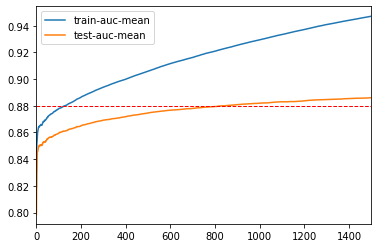

In [197]:
cvresult.loc[:,['train-auc-mean','test-auc-mean']].plot()
plt.axhline(0.88, color='r', linestyle='dashed', linewidth=1, label='0.88')

This is a good result but there's still a significant overfitting.

#### CatBoost

In [199]:
def cb_tune(params, param_tune, features_train, target_train):
    est = CatBoostClassifier(**params)
    gsearch = GridSearchCV(estimator = est, param_grid = param_tune, scoring='roc_auc',n_jobs=4,iid=False, cv=4)
    gsearch.fit(features_train, target_train)
    print(gsearch.best_params_, gsearch.best_score_)
    return gsearch

In [200]:
paramsCB = {
    'learning_rate': 0.1,
 'n_estimators':1000,
 'depth':5,
 'random_strength':0.8,
 'subsample':0.8,
 'reg_lambda':3,
 'loss_function': 'Logloss',
    'eval_metric': 'AUC',
 'thread_count':4,
 'scale_pos_weight':3,
    'logging_level':'Silent',
 'random_seed':27
}
dtrain = cb.Pool(data=features_train, label=target_train)
cvresult = cb.cv(dtrain, paramsCB, num_boost_round=paramsCB['n_estimators'], nfold=4, early_stopping_rounds=50, \
                 stratified =True, shuffle=True, logging_level='Silent')
cvresult.iloc[-1,:]

iterations            592.000000
test-AUC-mean           0.904987
test-AUC-std            0.011096
test-Logloss-mean       0.410424
test-Logloss-std        0.033175
train-Logloss-mean      0.167351
train-Logloss-std       0.004735
Name: 592, dtype: float64

Tuning depth, l2_leaf_reg:

In [201]:
# Updating n_estimators and tuning max_depth
paramsCB['n_estimators'] = cvresult.shape[0]
param_tune1 = {
 'depth':range(3,10,1),
}
gsearch1 = cb_tune(paramsCB, param_tune1, features_train, target_train)

{'depth': 4} 0.9061234769049201


Tuning l2_leaf_reg:

In [202]:
# Updating n_estimators and tuning max_depth, min_child_weight
paramsCB['depth'] = gsearch1.best_params_['depth']
paramsCB['logging_level']='Silent'
param_tune2 = {
 'reg_lambda':range(2,30,1)
}
gsearch2 = cb_tune(paramsCB, param_tune2, features_train, target_train)

{'reg_lambda': 3} 0.9061234769049201


In [203]:
paramsCB['reg_lambda'] = gsearch2.best_params_['reg_lambda']
cvresult = cb.cv(dtrain, paramsCB, num_boost_round=paramsCB['n_estimators'], nfold=4, early_stopping_rounds=50, \
                 stratified =True, shuffle=True, logging_level='Silent')
cvresult.iloc[-1,:]

iterations            592.000000
test-AUC-mean           0.910660
test-AUC-std            0.010136
test-Logloss-mean       0.387253
test-Logloss-std        0.025703
train-Logloss-mean      0.213626
train-Logloss-std       0.004450
Name: 592, dtype: float64

Tuning scale_pos_weight because the data is imbalanced:

In [204]:
#  Updating n_estimators and tuning scale_pos_weight
paramsCB['n_estimators']=cvresult.shape[0]
param_tune3 = {
    'scale_pos_weight':[1,2,3,4,5,6,7,8,9,10]
}
gsearch3 = cb_tune(paramsCB, param_tune3, features_train, target_train)

{'scale_pos_weight': 1} 0.9080652681602254


In [205]:
#  Updating scale_pos_weight and tuning random_strength
paramsCB['scale_pos_weight']=gsearch3.best_params_['scale_pos_weight']
param_tune4 = {
    'random_strength':[0.2,0.5,0.8, 1]
}
gsearch4 = cb_tune(paramsCB, param_tune4, features_train, target_train)

{'random_strength': 0.2} 0.9105580665331877


In [206]:
#  Updating scale_pos_weight and tuning subsample
paramsCB['random_strength']=gsearch4.best_params_['random_strength']
param_tune5 = {
    'subsample':[i/10.0 for i in range(6,10)]
}
gsearch5 = cb_tune(paramsCB, param_tune5, features_train, target_train)

{'subsample': 0.8} 0.9105580665331877


In [207]:
paramsCB['learning_rate'] = 0.01
paramsCB['n_estimators'] = 1500
cvresult = cb.cv(dtrain, paramsCB, num_boost_round=paramsCB['n_estimators'], nfold=4, early_stopping_rounds=50, \
                 stratified =True, shuffle=True, logging_level='Silent')
cvresult.iloc[-1,:]

iterations            1499.000000
test-AUC-mean            0.890002
test-AUC-std             0.014650
test-Logloss-mean        0.349297
test-Logloss-std         0.018981
train-Logloss-mean       0.303328
train-Logloss-std        0.005919
Name: 1499, dtype: float64

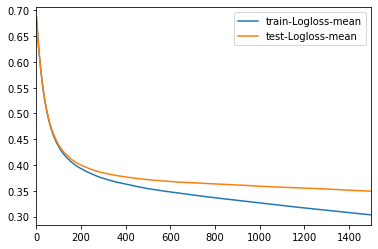

In [209]:
cvresult.loc[:,['train-Logloss-mean','test-Logloss-mean']].plot()

The result is slightly better than xgb but it looks like there's less overfitting.

### Final evaluation

In [256]:
def test_summary(model, features_train, target_train,features_test,target_test):
    #Predict test set:
    predictions = model.predict(features_test)
    predprob = model.predict_proba(features_test)[:,1]
    predictions_train = model.predict(features_train)
    predprob_train = model.predict_proba(features_train)[:,1]

    rocauc_test=roc_auc_score(target_test, predprob)
    rocauc_train = roc_auc_score(target_train, predprob_train)
    acc_test = accuracy_score(target_test, predictions)
    acc_train = accuracy_score(target_train, predictions_train)   
    
    print('Test set ROC-AUC: %.4f' % rocauc_test, \
         '\nTest set accuracy: %.4f' % acc_test,\
          '\nTest set f1: %.4f' % f1_score(target_test, predictions),\
          '\n\nTrain set ROC-AUC: %.4f' % rocauc_train, \
         '\nTrain set accuracy: %.4f' % acc_train, \
          '\nTrain set f1: %.4f' % f1_score(target_train, predictions_train)
         )
    
    # Thresholds
    fpr_test, tpr_test, roc_thresholds_test = roc_curve(target_test, predprob)
    fpr_train, tpr_train, roc_thresholds_train = roc_curve(target_train, predprob_train)

    accuracy_scores = []
    for thresh in roc_thresholds_test:
        accuracy_scores.append(accuracy_score(target_test, [1 if m > thresh else 0 for m in predprob]))

    accuracies = np.array(accuracy_scores)
    max_accuracy_test = accuracies.max() 
    max_accuracy_threshold_test =  roc_thresholds_test[accuracies.argmax()]

    print('\n\n Test set max accuracy threshold: %.4f' % max_accuracy_threshold_test, \
         '\n Test set max accuracy: %.4f' % max_accuracy_test)
    
    # ROCAUC curve
    plt.figure(figsize=(10,5))
    plt.plot(fpr_test, tpr_test, color='b', \
             label=f'Test, ROC AUC={rocauc_test:.4f}')
    plt.plot(fpr_train, tpr_train, color='g', label=f'Train, ROC AUC={rocauc_train:.4f}') 
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.axvline(fpr_test[tpr_test.argmax()], color='r', linestyle='dashed', linewidth=1,\
                label=f'Thresh={(roc_thresholds_test[tpr_test.argmax()]):.4f} Min false-negatives, Accuracy={accuracies[tpr_test.argmax()]:.4f}')

    plt.axvline(fpr_test[np.max(np.where(fpr_test==0))], color='orange', linestyle='dashed', linewidth=1,\
                label=f'Thresh={(roc_thresholds_test[np.max(np.where(fpr_test==0))]):.4f} Min false-positives, Accuracy={accuracies[np.max(np.where(fpr_test==0))]:.4f}')

    plt.axvline(fpr_test[np.where(roc_thresholds_test==max_accuracy_threshold_test)], color='pink', linestyle='dashed', linewidth=2,\
                label=f'Thresh={(max_accuracy_threshold_test):.4f} Max Accuracy={max_accuracy_test:.4f}')
    plt.axvline(fpr_test[(np.abs(roc_thresholds_test - 0.5)).argmin()], color='yellow', linestyle='dashed', linewidth=4,\
                label=f'Thresh={(roc_thresholds_test[(np.abs(roc_thresholds_test - 0.5)).argmin()]):.4f} Accuracy={accuracies[(np.abs(roc_thresholds_test - 0.5)).argmin()]:.4f} FPR={fpr_test[(np.abs(roc_thresholds_test - 0.5)).argmin()]:.4f} TPR={tpr_test[(np.abs(roc_thresholds_test - 0.5)).argmin()]:.4f}')

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc='lower center', fontsize=12)        
    plt.title(f'ROC Curve')
    plt.tight_layout()

Test set ROC-AUC: 0.8837 
Test set accuracy: 0.6905 
Test set f1: 0.6148 

Train set ROC-AUC: 0.9387 
Train set accuracy: 0.7243 
Train set f1: 0.6528


 Test set max accuracy threshold: 0.8947 
 Test set max accuracy: 0.8427


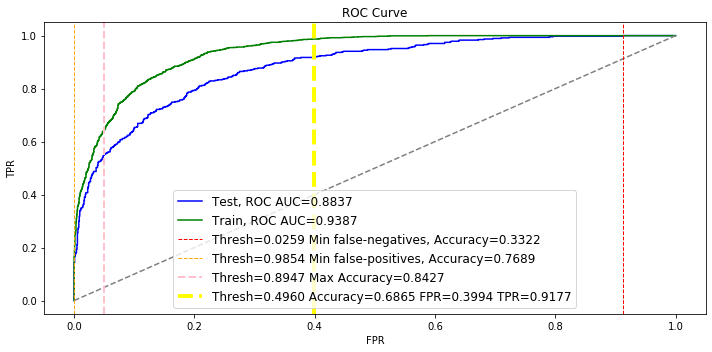

In [257]:
# Testing XGB for comparison
xgb_model= XGBClassifier(**params)
xgb_model.fit(features_train, target_train,eval_set=[(features_test, target_test)], eval_metric='auc', verbose=False)

test_summary(xgb_model, features_train, target_train,features_test,target_test)

- ROCAUC is 0.8837 but accuracy is quite low 0.69 (less than accuracy of constant model of 0's)
- There's overfitting on train set (6% larger ROCAUC)
- Tuning scale_pos_weight was a mistake since it resulted in scale_pos_weight=9 which means a large bias for the minority class "1" and a very large threshold for max accuracy 0.84 to correct the bias.
- As a result this model performs better when we want to avoid false-negatives with FN ratio of ~10%. 

Test set ROC-AUC: 0.8892 
Test set accuracy: 0.8478 
Test set f1: 0.6748 

Train set ROC-AUC: 0.9211 
Train set accuracy: 0.8684 
Train set f1: 0.7134


 Test set max accuracy threshold: 0.4890 
 Test set max accuracy: 0.8501


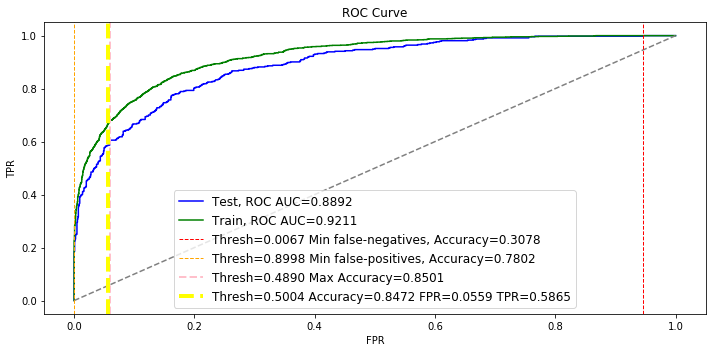

In [258]:
# Final testing catBoost
model = CatBoostClassifier(**paramsCB)
dtest = cb.Pool(data=features_test, label=target_test)
model.fit(features_train, target_train,eval_set=dtest, verbose=False)

test_summary(model, features_train, target_train,features_test,target_test)

- ROCAUC is 0.889 and accuracy is not bad 0.8478 (more than constant model's accuracy)
- There's less overfitting on train set than with xgb (3% larger ROCAUC)
- Tuning scale_pos_weight resulted in scale_pos_weight=1 which means no bias for the minority class "1" and thus the threshold for max accuracy 0.85 is a little less than 0.5.
- As a result this model performs better when we want to avoid false-positives with FP ratio of ~5%.

### Business Implications

- The model has ROC AUC of 0.889 : a moderate reliablity regarding it's seperability between leaving to active customers


- Accuracy is 0.845 : we have the risk of mistaking less than 16% of customers.


- Max accuracy is 0.85 for thresh=0.489 : since we maximized auc-roc in an unbalanced data the maximun accuracy is up to 15% wrong classifications.


- If the company cares more about false-negative mistakes, i.e. classifying a leaving customer as active and thus missing the chance to retain him, then this model is not an ideal one because it has FN ratio of ~40%. I would recommend lowering the threshold a little from 0.5 probability to make the model more sensitive to actual positives (leaving customers), but it's better to train a different model because "1" is the minority class (26%) and this model can't minimize false-negatives without lowering accuracy too much.


- If the company cares more about false-positive mistakes, i.e. classifying an active customer as leaving and thus offering him a cheaper plan, than the model already gives quite good FP ratio of ~5%.